# Project Human Language Technology - OffensEval2019
# Task 1
## BERT Medium
This notebook will explore a model for competition "OffensEval 2019: Identifying and Categorizing Offensive Language in Social Media" using BERT Medium. \\
BERT Medium a pre-trained model with structure is __L = 8 and H = 512__ \\
Matricola: 505252 Michele Morisco

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!cp drive/MyDrive/Library/PreProcessing.py .
!cp drive/MyDrive/Library/BERTBase.py .
!cp drive/MyDrive/Library/AnalysisGraph.py .

In [ ]:
#!pip install pytorch-pretrained-bert pytorch-nlp
!pip install emoji --upgrade
!pip install wordsegment
!pip install transformers 
!pip install ekphrasis

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 216 kB 4.8 MB/s 
  Created wheel for emoji: filename=emoji-2.1.0-py3-none-any.whl size=212392 sha256=72d62fd65f950187a5f8342e8ec07d6a7e676578821c721c2e9e0681fccd010d
  Stored in directory: /root/.cache/pip/wheels/77/75/99/51c2a119f4cfd3af7b49cc57e4f737bed7e40b348a85d82804
Successfully built emoji
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.8 MB 4.8 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 5.3 MB 4.7 MB/s 
     |████████████████████████████████| 7.6 MB 46.7 MB/s 
     |████████████████████████████████| 163 kB 80.1 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |██████████████████████████████

In [ ]:
from PreProcessing import load_dataset
from BERTBase import run_with_kfold, evaluateFinal
from AnalysisGraph import show_confusion_matrix, show_report, showWrongPredictions

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


In [ ]:
import string
string.punctuation
import csv
import pandas as pd
import numpy as np

from transformers import BertForSequenceClassification, BertConfig, BertModel, BertTokenizer, AdamW, get_linear_schedule_with_warmup
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import f1_score
import torch
from torch import tensor
import torch.nn as nn
from tqdm import tqdm, trange
import matplotlib.pyplot as plt
import random

#% matplotlib inline

#Random seed initialization for replicability of results
torch.manual_seed(0)
random.seed(0)
np.random.seed(0)

import warnings
warnings.filterwarnings("ignore")

In [ ]:
if torch.cuda.is_available():       
    device = torch.device("cuda")
    print(f'There are {torch.cuda.device_count()} GPU(s) available.')
    print('Device name:', torch.cuda.get_device_name(0))
    !nvidia-smi
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
Device name: Tesla T4
Thu Oct 13 09:47:11 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   32C    P8    11W /  70W |      3MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                    

In [ ]:
#SET THE PARAMETERS FOR TRAINING 
H_PARAMETERS = {'model_name': 'prajjwal1/bert-medium', 'unit_layers' : [512, 64, 32, 2], 'dropout' : 0.5, 'folds' : 4, 'batch_size': 32, 
                'warmup_proportion' : 0.1, 'learning_rate': 2e-5, 'loss' : nn.CrossEntropyLoss(), 'num_epochs': 3, 'device' : device}

In [ ]:
# Function to calculate the accuracy of our predictions vs labels
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

In [ ]:
#dataset = open("OLID/olid-training-v1.0.tsv")
data, label = load_dataset(dataset_path = 'drive/MyDrive/HLT/OLID/')

data.subtask_a.value_counts()

Word statistics files not found!
Downloading... done!
Unpacking... done!
Reading english - 1grams ...
generating cache file for faster loading...
reading ngrams /root/.ekphrasis/stats/english/counts_1grams.txt
Reading english - 2grams ...
generating cache file for faster loading...
reading ngrams /root/.ekphrasis/stats/english/counts_2grams.txt
Reading english - 1grams ...
user canada need another cuck already enough looney leave liberals fking great country qp roof trudeau must go


NOT    8840
OFF    4400
Name: subtask_a, dtype: int64

In [ ]:
data.tweet.sample(20)

12823                     user good antifa violent fascism
12290    user de create slowly stealthily since conserv...
8474     christian kabasele reveal secrets behind watfo...
4676     user oppose neutral jurist sit scotus weigh me...
397      user wonder apologize diamond silk call minstr...
10957    user know canada want seem enough problems lib...
3311                                        user love maga
12936    user agree still conservatives heart may hate ...
8575                         play water slider summer http
4392     kyky u love u anfield putain la cliiimmmm liv psg
7673     user compromise active investigation sound lik...
12966    fill sky chemicals frequencies ido consent con...
12215    love one another starlight darkness surround m...
5480     verge collapse break wave cannot explain whole...
3535                user hair polyester fibers yoda puppet
4425                           user first regression laugh
5523     user well brandon conservatives get elect red .

In [ ]:
X_train = list(data.tweet.values)

In [ ]:
MAX_SEQ_LENGTH = 64

tokenizer = BertTokenizer.from_pretrained(H_PARAMETERS['model_name'], do_lower_case=True)
sentences = data.tweet.values
tokens = tokenizer(X_train, padding=True, truncation=True, max_length=MAX_SEQ_LENGTH)

# Create input ids
input_ids = []
# Create attention masks
attention_masks = []

input_ids_train = torch.tensor(tokens['input_ids'])
attention_masks_train  = torch.tensor(tokens['attention_mask'])

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/286 [00:00<?, ?B/s]

In [ ]:
print('Original: ', sentences[0])
print('Token IDs:', input_ids_train[0])

Original:  user ask native americans take
Token IDs: tensor([ 101, 5310, 3198, 3128, 4841, 2202,  102,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0])


In [ ]:
loss_fn = nn.CrossEntropyLoss()

In [ ]:
test_data, label_test = load_dataset(dataset_path = 'drive/MyDrive/HLT/OLID/', dataset='testset-levela.tsv', dataset_label='labels-levela.csv')
X_test = list(test_data.tweet.values)

Reading english - 1grams ...
Reading english - 2grams ...
Reading english - 1grams ...
bigg boss tamil janani task go first final listclapping hand clap hand clap hand clap hand


In [ ]:
tokens = tokenizer(X_test, padding=True, truncation=True, max_length=MAX_SEQ_LENGTH)

# Create input ids
input_ids = []
# Create attention masks
attention_masks = []

input_ids_test = torch.tensor(tokens['input_ids'])
attention_masks_test  = torch.tensor(tokens['attention_mask'])

test_dataset = TensorDataset(input_ids_test, attention_masks_test, torch.tensor(label_test))
test_sampler = SequentialSampler(test_dataset)
test_dataloader = DataLoader(test_dataset, sampler=test_sampler, batch_size=len(test_dataset))

Downloading:   0%|          | 0.00/167M [00:00<?, ?B/s]

Some weights of the model checkpoint at prajjwal1/bert-medium were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Sequential(
  (0): Linear(in_features=512, out_features=64, bias=True)
  (1): ReLU()
  (2): Dropout(p=0.5, inplace=False)
  (3): Linear(in_features=64, out_features=32, bias=True)
  (4): ReLU()
  (5): Dropout(p=0.5, inplace=False)
  (6): Linear(in_features=32, out_features=2, bias=True)
)
Start training...

 Epoch  |  Batch  |  Train Loss  | F1 Train  |  Val Loss  |  Val Acc  |  F1 Val   |  Elapsed 
-----------------------------------------------------------------------------------------------
   1    |   20    |   0.667393   |   0.44    |     -      |     -     |     -     |   4.61   
   1    |   40    |   0.650753   |   0.43    |     -      |     -     |     -     |   2.11   
   1    |   60    |   0.633581   |   0.42    |     -      |     -     |     -     |   2.10   
   1    |   80    |   0.608767   |   0.47    |     -      |     -     |     -     |   2.11   
   1    |   100   |   0.615614   |   0.55    |     -      |     -     |     -     |   2.11   
   1    |   120   |   0.607244 

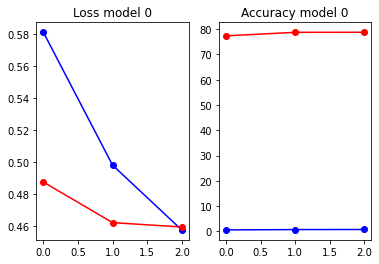

Some weights of the model checkpoint at prajjwal1/bert-medium were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Sequential(
  (0): Linear(in_features=512, out_features=64, bias=True)
  (1): ReLU()
  (2): Dropout(p=0.5, inplace=False)
  (3): Linear(in_features=64, out_features=32, bias=True)
  (4): ReLU()
  (5): Dropout(p=0.5, inplace=False)
  (6): Linear(in_features=32, out_features=2, bias=True)
)
Start training...

 Epoch  |  Batch  |  Train Loss  | F1 Train  |  Val Loss  |  Val Acc  |  F1 Val   |  Elapsed 
-----------------------------------------------------------------------------------------------
   1    |   20    |   0.666643   |   0.47    |     -      |     -     |     -     |   2.33   
   1    |   40    |   0.625883   |   0.45    |     -      |     -     |     -     |   2.23   
   1    |   60    |   0.641043   |   0.43    |     -      |     -     |     -     |   2.23   
   1    |   80    |   0.625804   |   0.44    |     -      |     -     |     -     |   2.23   
   1    |   100   |   0.578278   |   0.47    |     -      |     -     |     -     |   2.23   
   1    |   120   |   0.580992 

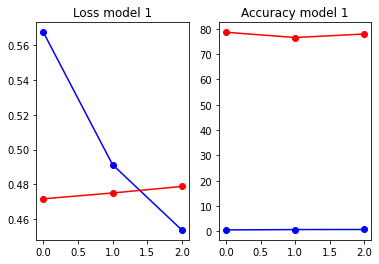

Some weights of the model checkpoint at prajjwal1/bert-medium were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Sequential(
  (0): Linear(in_features=512, out_features=64, bias=True)
  (1): ReLU()
  (2): Dropout(p=0.5, inplace=False)
  (3): Linear(in_features=64, out_features=32, bias=True)
  (4): ReLU()
  (5): Dropout(p=0.5, inplace=False)
  (6): Linear(in_features=32, out_features=2, bias=True)
)
Start training...

 Epoch  |  Batch  |  Train Loss  | F1 Train  |  Val Loss  |  Val Acc  |  F1 Val   |  Elapsed 
-----------------------------------------------------------------------------------------------
   1    |   20    |   0.661564   |   0.50    |     -      |     -     |     -     |   2.42   
   1    |   40    |   0.645255   |   0.43    |     -      |     -     |     -     |   2.32   
   1    |   60    |   0.631753   |   0.52    |     -      |     -     |     -     |   2.31   
   1    |   80    |   0.614665   |   0.54    |     -      |     -     |     -     |   2.31   
   1    |   100   |   0.563416   |   0.59    |     -      |     -     |     -     |   2.31   
   1    |   120   |   0.554718 

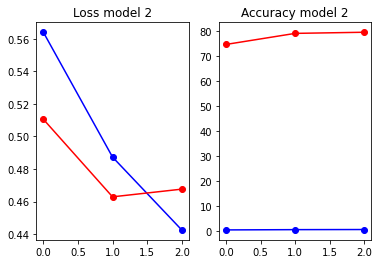

Some weights of the model checkpoint at prajjwal1/bert-medium were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Sequential(
  (0): Linear(in_features=512, out_features=64, bias=True)
  (1): ReLU()
  (2): Dropout(p=0.5, inplace=False)
  (3): Linear(in_features=64, out_features=32, bias=True)
  (4): ReLU()
  (5): Dropout(p=0.5, inplace=False)
  (6): Linear(in_features=32, out_features=2, bias=True)
)
Start training...

 Epoch  |  Batch  |  Train Loss  | F1 Train  |  Val Loss  |  Val Acc  |  F1 Val   |  Elapsed 
-----------------------------------------------------------------------------------------------
   1    |   20    |   0.647016   |   0.42    |     -      |     -     |     -     |   2.41   
   1    |   40    |   0.634263   |   0.40    |     -      |     -     |     -     |   2.31   
   1    |   60    |   0.623856   |   0.40    |     -      |     -     |     -     |   2.32   
   1    |   80    |   0.597530   |   0.44    |     -      |     -     |     -     |   2.32   
   1    |   100   |   0.592822   |   0.47    |     -      |     -     |     -     |   2.31   
   1    |   120   |   0.596973 

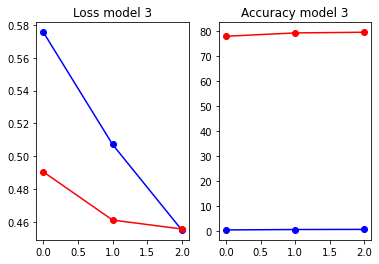

------RESULT------


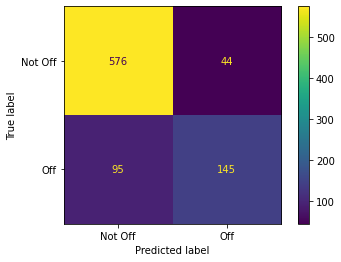

              precision    recall  f1-score   support

     Not Off     0.8584    0.9290    0.8923       620
         Off     0.7672    0.6042    0.6760       240

    accuracy                         0.8384       860
   macro avg     0.8128    0.7666    0.7842       860
weighted avg     0.8330    0.8384    0.8320       860

f1_score test tweets: 0.7841611009697764


In [ ]:
models, preds_ensemble = run_with_kfold(input_ids_train, attention_masks_train, test_dataloader, torch.tensor(label), label_test, H_PARAMETERS)

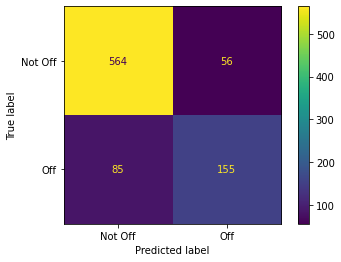

              precision    recall  f1-score   support

     Not Off     0.8690    0.9097    0.8889       620
         Off     0.7346    0.6458    0.6874       240

    accuracy                         0.8360       860
   macro avg     0.8018    0.7778    0.7881       860
weighted avg     0.8315    0.8360    0.8326       860

Bert model 0 tweets testset result => Loss: 0.3877367377281189 Accuracy: 83.6046511627907 F1 score: 78.81251539788126


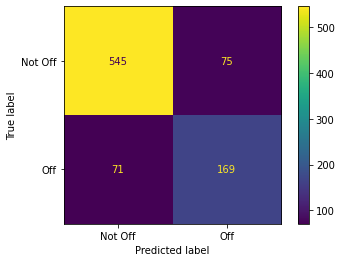

              precision    recall  f1-score   support

     Not Off     0.8847    0.8790    0.8819       620
         Off     0.6926    0.7042    0.6983       240

    accuracy                         0.8302       860
   macro avg     0.7887    0.7916    0.7901       860
weighted avg     0.8311    0.8302    0.8307       860

Bert model 1 tweets testset result => Loss: 0.3912300169467926 Accuracy: 83.02325581395348 F1 score: 79.01120650458691


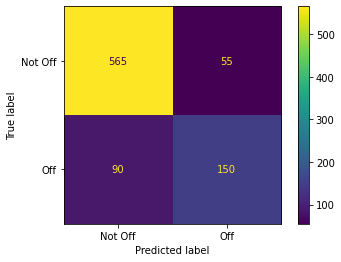

              precision    recall  f1-score   support

     Not Off     0.8626    0.9113    0.8863       620
         Off     0.7317    0.6250    0.6742       240

    accuracy                         0.8314       860
   macro avg     0.7972    0.7681    0.7802       860
weighted avg     0.8261    0.8314    0.8271       860

Bert model 2 tweets testset result => Loss: 0.39635783433914185 Accuracy: 83.13953488372093 F1 score: 78.02159065873539


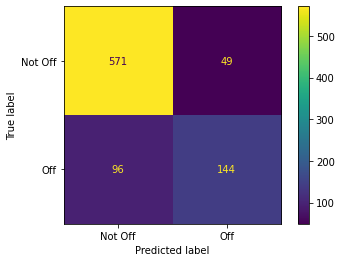

              precision    recall  f1-score   support

     Not Off     0.8561    0.9210    0.8873       620
         Off     0.7461    0.6000    0.6651       240

    accuracy                         0.8314       860
   macro avg     0.8011    0.7605    0.7762       860
weighted avg     0.8254    0.8314    0.8253       860

Bert model 3 tweets testset result => Loss: 0.384473979473114 Accuracy: 83.13953488372093 F1 score: 77.62309540600533


In [ ]:
for i in range(len(models)):
  models[i].to(device)
  val_loss, val_accuracys, f1_value_tweets = evaluateFinal(models[i], test_dataloader, H_PARAMETERS['device'], H_PARAMETERS['loss'])
  models[i].to('cpu')
  print("Bert model {0} tweets testset result => Loss: {1} Accuracy: {2} F1 score: {3}".format(i, val_loss, val_accuracys, f1_value_tweets))

In [ ]:
showWrongPredictions(test_data, torch.tensor(label), preds_ensemble)

       id                   tweet
14  12588  user nigga ware da hit
       id                                   tweet
15  34263  stop kavanaugh liar like rest gop http
       id                                              tweet
27  49139  user put delauro police lineup identify bag la...
       id                                              tweet
38  46444  ariana asesina serious holy shit please fuck a...
       id                             tweet
39  60587  user hide ugly personality worst
      id                                              tweet
0  15923  isq wheres server dump nike dec las fisa democ...
      id                                              tweet
1  27014  constitution day revere conservatives hat prog...
      id                                              tweet
3  13876  watch boomer get news still parole always make...
      id                                      tweet
7  65507  user get feel kiss behind humiliate later
      id                            